In [2]:
import numpy as np
import matplotlib.pyplot as plt
%pylab inline
plt.rcParams["figure.figsize"] = (10,10)

Populating the interactive namespace from numpy and matplotlib


2D Ising Gauge Hamiltonian:
$
H = \sum_p \Pi_{i\in p} \sigma^z_i
$

In [3]:
'''
    Hamiltonian:
    H = \sum_p \Pi \sigma_p
    
    - s - - - s - - - s - - - s -
          |       |       |
          s i,j+1 s (...) s 
          |       |       |
    - s - - - s - - - s - - - s -
          |       |       |
          s  i,j  s i+1,j s 
          |       |       |
    - s - - - s - - - s - - - s -
          |       |       |
          s       s       s

'''
# number of sites
N=4
J=1.

In [4]:
def initialize():
    '''
    returns:
        random spin configuration with format NxNx2 where
    
    note:
        i,j denotes the plaquette to the right / up from vertex i,j and xy usually denotes 
        the spin at + x/2 or + y/2 to the center.
    '''
    
    spins = 2*np.random.randint(2, size=((N, N,2))) - np.ones((N,N,2))
    return spins

In [5]:
def total_energy(spins):
    '''
    returns:
        total energy of the spin configuration
    
    input: 
        spins     :  spin configuration 
    '''
    
    N = np.shape(spins)[0]
    energy = 0
    for i in range(N):
        i_left = (i+N-1)%N
        for j in range(N):
            j_up = (N+j-1)%N
            en = -J*(spins[i,j, 0]*spins[i_left, j, 0]*spins[i,j,1]*spins[i,j_up, 1])
            energy += en
    return energy

In [6]:
def dE(spins, i, j, xy):
    '''
    returns:
        energy difference after flipping the 'xy' spin at plaquette ('i','j')
    
    note:
        energy before flipping: 
          for x spin: 
            s(i,j)_x * [s(i-1,j)_x * s(i,j-1)_y * s(i,j)_y + s(i+1,j)_x * s(i+1,j-1)_y * s(i+1,j)_y]
          for y spin: 
            s(i,j)_y * [s(i-1,j)_x * s(i,j-1)_y * s(i,j)_x + s(i-1,j+1)_x * s(i,j+1)_y * s(i,j+1)_x]
        
        after flipping, energy is -s(i,j)*[...] -> difference is 2*s(i,j)*[...]
    '''
    
    i_right = (i+1)%N
    i_left = (i+N-1)%N
    j_down = (j+1)%N
    j_up = (N+j-1)%N
    if xy == 0: # the x spin should be updated
        left_plaquette = spins[i,j,0]*spins[i_left, j,0]*spins[i,
                j_up,1]*spins[i,j,1]
        right_plaquette = spins[i,j,0]*spins[i_right, j,0]*spins[i_right,
                j_up,1]*spins[i_right,j,1]

        return 2*J*(left_plaquette+right_plaquette)
    else:
        up_plaquette = spins[i,j,1]*spins[i_left, j,0]*spins[i,
                j_up,1]*spins[i,j,0]
        down_plaquette = spins[i,j,1]*spins[i_left, j_down,0]*spins[i,
                j_down,1]*spins[i,j_down,0]

        return 2*J*(up_plaquette + down_plaquette)

In [7]:
def single_spin_update(spins, T):
    '''
    performs a single step in a Metropolis single-spin update
    
    input:
        spins  :  spin configuration
        T      :  temperature for the probability
    '''
    
    # first, choose the plaquette
    i,j = np.random.randint(N, size=2)
    # now choose whether to look at the x or y spin
    xy = np.random.randint(2)
    DE = dE(spins, i,j, xy)
    r = np.random.random()
    if r < np.exp(-DE/T):
        spins[i,j,xy] *= -1

In [8]:
def vertex_update(spins):
    '''
    performs a vertex update, i.e., flipps all the spins around the vertex (i,j)
    Since this update does not change the energy, it's performed with probability 1.
    '''
    
    # pick a vertex
    i,j = random.randint(N, size=2)
    i_left = (i+N-1)%N
    j_up = (N+j-1)%N
    # and flip every spin connected to it
    spins[i_left, j,0]*=-1
    spins[i_left, j_up,0]*=-1
    spins[i, j_up,1]*=-1
    spins[i_left, j_up,1]*=-1

In [13]:
def plot_configuration(spins):
    '''
    
    this is just a helper function to plot the configuration of spins  given by 'spins'
    note that (i,j) denotes a vertex coordinate, such that the location of the plaquette
    center is at (i+0.5, j+0.5) and thus, the x spin is at (i+1, j+0.5) etc.
    
    '''
    N = np.shape(spins)[1]
    fig, ax = plt.subplots()
    fig.add_axes()
    ax = fig.axes[0]
    for i in range(N+1):
        ax.plot([i, i], [0,N], 'k')
        ax.plot([0,N], [i,i], 'k')

    colors = ['b', 'r'] # note: blue is down, red is up!
    for i in range(N):
        for j in range(N):
            fig.gca().add_patch(plt.Circle((i+1,j+0.5), radius=0.2, fc=colors[int((spins[i,j,0]+1)/2.)]))
            fig.gca().add_patch(plt.Circle((i+0.5,j+1), radius=0.2, fc=colors[int((spins[i,j,1]+1)/2.)]))
            
    for j in range(N):
        fig.gca().add_patch(plt.Circle((0,j+0.5), radius=0.2, fc=colors[int((spins[-1,j,0]+1)/2.)]))
    for i in range(N):
        fig.gca().add_patch(plt.Circle((i+0.5,0), radius=0.2, fc=colors[int((spins[i,-1,1]+1)/2.)]))
    
    ax.set_ylim(-1,N+1)
    ax.set_xlim(-1,N+1)
    ax.set_aspect('equal')
    plt.xlabel("x")
    plt.ylabel("y")
    fig.show()

In [14]:
Tconfig = initialize()
not_yet = True
while not_yet:
    single_spin_update(Tconfig, 0.01)
    if total_energy(Tconfig)==-16: break

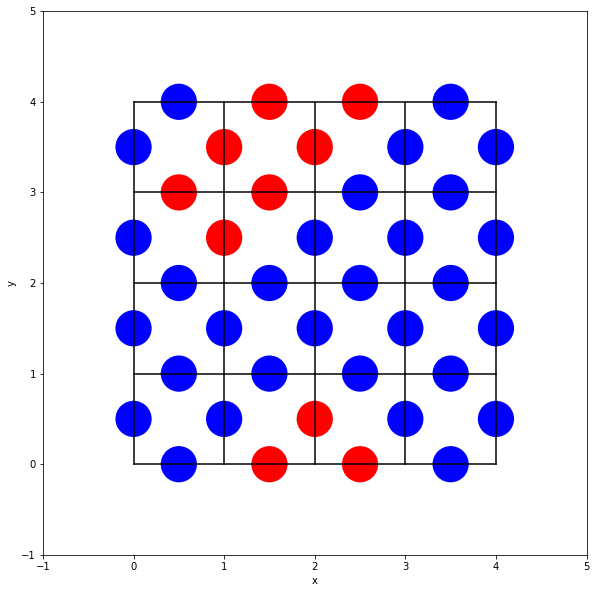

In [16]:
plot_configuration(Tconfig)

In [19]:
configs = np.loadtxt("configs.txt")
labels = np.loadtxt("labels.txt")

In [20]:
Nc = int(np.sqrt(len(configs[0])/2))

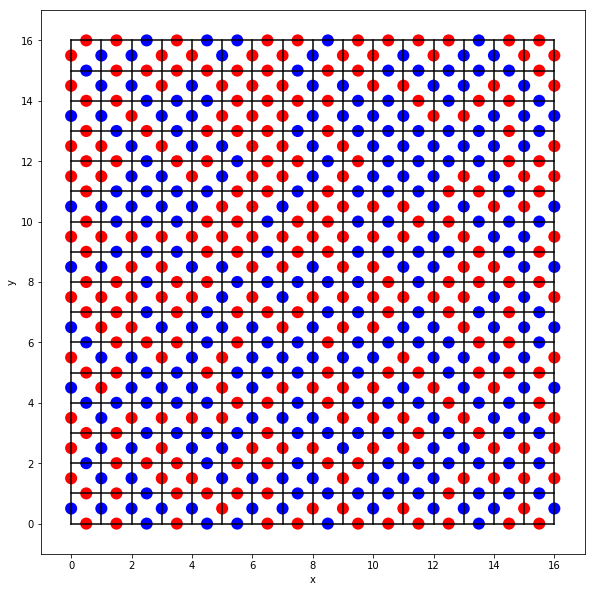

In [22]:
plot_configuration(np.reshape(configs[0], (Nc, Nc, 2)))

In [24]:
total_energy(np.reshape(configs[0], (Nc, Nc, 2)))

-256.0